In [9]:
import datetime
import time
import numpy as np
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.window import Window
from pyspark.sql import DataFrame as SparkDataFrame
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('DEV-MIND').getOrCreate()


In [10]:
from metrecs.utils import (
    harmonic_number,
    normalized_scaled_harmonic_number_series,
    compute_normalized_distribution_multiple_categories,
    opt_merge_max_mappings,
    avoid_distribution_misspecification,
    user_level_RADio_multicategorical
)

In [11]:
def read_articles(path: str) -> SparkDataFrame:
    myschema = StructType([
                StructField('_c0', StringType(), True),
                StructField('newsid', StringType(), True),
                StructField('title', StringType(), True),
                StructField('category', StringType(), True),
                StructField('subcategory', StringType(), True),
                StructField('cat_subcat', ArrayType(StringType()), True),
                StructField('abstract', StringType(), True),
                StructField('publication_date', StringType(), True),
                StructField('url', StringType(), True)
            ])
    articles_df = spark.read.json(path, schema=myschema)
    articles_df = articles_df.withColumn('cat_as_list', F.udf(lambda x: [x], ArrayType(StringType()))(F.col('category')))
    print('Nr of unique articles', articles_df.select('newsid').distinct().count())
    return articles_df

def read_behavior(path: str) -> SparkDataFrame:
    myschema = StructType([
        StructField('index', IntegerType(), True),
        StructField('user', StringType(), True),
        StructField('datetime', StringType(), True),
        StructField('behavior_string', StringType(), True),
        StructField('preselection_string', StringType(), True)
    ])
    
    behaviors_presel_df = spark.read.csv(path, sep="\t", schema=myschema)#.drop('index')
    behaviors_presel_df = behaviors_presel_df.withColumn('behavior_array', F.split(F.col('behavior_string'),' ')).drop('behavior_string')
    behaviors_presel_df = behaviors_presel_df.withColumn('preselection_array', F.split(F.col('preselection_string'),' ')).drop('preselection_string')
    behaviors_presel_df = behaviors_presel_df.withColumn('pool_array', F.udf(lambda x: [i.split('-')[0] for i in x], ArrayType(StringType()))(F.col('preselection_array')))
                                           
    return behaviors_presel_df
  
def get_top_rec_ids_array(pred_df: SparkDataFrame, behaviors_presel_df: SparkDataFrame, top_k: int) -> SparkDataFrame:
    # Create a df with one row per user that contains only the top_k recommendations, that is the newsid and not the position of the preselection
    pred_df = pred_df.filter(F.col('size_list') >= top_k)
    pred_preselection_df = pred_df.join(behaviors_presel_df.select('index', 'user', 'preselection_array'), 'index')
    pred_preselection_df = pred_preselection_df.withColumn('pred_slice_id', F.udf(lambda x,y: [str(y[indx]).split('-')[0] for indx, ele in enumerate(x) if ele <= top_k],
                                                                                  ArrayType(StringType()))(F.col('pred_rank'), F.col('preselection_array')))
    pred_preselection_df = pred_preselection_df.drop('preselection_array').drop('pred_rank')
    return pred_preselection_df
  
def read_predictions(path_predictions: str, behaviors_presel_df: SparkDataFrame, top_k: int, algo: str) -> tuple[SparkDataFrame, SparkDataFrame]:
    pred_df = spark.read.json(path_predictions)
    pred_df = pred_df.withColumn('size_list', F.size('pred_rank'))
    pred_df = pred_df.withColumnRenamed('impr_index','index')
    pred_df = pred_df.withColumn('algo', F.lit(algo))
    
    pred_preselection_df = get_top_rec_ids_array(pred_df, behaviors_presel_df, top_k = 2*top_k)
    return pred_df, pred_preselection_df


In [12]:
def get_cat(df: SparkDataFrame, articles_df: SparkDataFrame, column: str, cat_column: str, top_at: int, slice_col: bool=False) -> SparkDataFrame:
    df_exploded = df.select('*', F.posexplode(column).alias('rank', 'newsid'))\
                    .withColumn('rank', F.col('rank') + 1).drop(column)
        
    df_cat = df_exploded.join(articles_df.select('newsid',cat_column).distinct(), 'newsid', how='inner')
    w = Window.partitionBy('index').orderBy('rank')
    df_cat = df_cat.withColumn('sorted_cat_list', F.collect_list(cat_column).over(w))\
                   .withColumn('sorted_newsid_list', F.collect_list('newsid').over(w))\
                   .groupby('index').agg(F.max('sorted_cat_list').alias('sorted_cat_list'),
                                                              F.max('sorted_newsid_list').alias('sorted_newsid_list'))
    df_cat = df_cat.join(df.drop(column), 'index')
    if slice_col:
        df_cat = df_cat.withColumn('sorted_cat_list', F.slice('sorted_cat_list', 1, top_at))
        df_cat = df_cat.withColumn('sorted_newsid_list', F.slice('sorted_newsid_list', 1, top_at))
        df_cat = df_cat.withColumn('size_cat_list', F.size('sorted_cat_list'))
        df_cat = df_cat.filter(F.col('size_cat_list') == top_at)
    return df_cat

In [13]:
def get_classic_calibration(pred_preselection_df: SparkDataFrame, articles_df: SparkDataFrame, behaviors_presel_df: SparkDataFrame, cat_column: str, top_at: int) -> SparkDataFrame:
    df_cat = get_cat(pred_preselection_df, articles_df, 'pred_slice_id', cat_column, top_at, slice_col=True)
    
    df_cat_history = get_cat(behaviors_presel_df.select('index', 'user', 'behavior_array'), articles_df, 'behavior_array', cat_column, top_at, slice_col=False)
    df_cat_history = df_cat_history.selectExpr('index', 'user', 'sorted_cat_list as history_cat_list', 'sorted_newsid_list as history_newsid_list')
    
    df_rec_hist = df_cat.join(df_cat_history, ['index', 'user'], 'inner')
    
    df_calibration = df_rec_hist.withColumn('calibration', F.udf(lambda x,y: user_level_RADio_multicategorical(x,y,list(normalized_scaled_harmonic_number_series(len(x)))), DoubleType())\
                                                                 (F.col('sorted_cat_list'), F.col('history_cat_list')))
    return df_calibration

def get_classic_representation(pred_preselection_df: SparkDataFrame, articles_df: SparkDataFrame, behaviors_presel_df: SparkDataFrame, cat_column: str, top_at: int) -> SparkDataFrame:
    df_cat = get_cat(pred_preselection_df, articles_df, 'pred_slice_id', cat_column, top_at, slice_col=True)
    
    df_cat_pool = get_cat(behaviors_presel_df.select('index', 'user', 'pool_array'), articles_df, 'pool_array', cat_column, top_at, slice_col=False)
    df_cat_pool = df_cat_pool.selectExpr('index', 'user', 'sorted_cat_list as pool_cat_list', 'sorted_newsid_list as pool_newsid_list')
    
    df_rec_pool = df_cat.join(df_cat_pool, ['index', 'user'], 'inner')
    
    df_representation = df_rec_pool.withColumn('representation', F.udf(lambda x,y: user_level_RADio_multicategorical(x,y,list(normalized_scaled_harmonic_number_series(len(x)))), DoubleType())\
                                                                       (F.col('sorted_cat_list'), F.col('pool_cat_list')))
    return df_representation

def get_classic_fragmentation(pred_preselection_df: SparkDataFrame, articles_df: SparkDataFrame, cat_column: str, top_at: int, sample_size: float=0.05) -> SparkDataFrame:
    df_cat = get_cat(pred_preselection_df, articles_df, 'pred_slice_id', cat_column, top_at, slice_col=True)
    df_cat_cat = df_cat.crossJoin(df_cat.sample(sample_size)\
                                  .selectExpr('index as other_index', 'user as other_user', 'sorted_cat_list as rec_cat_list', 'sorted_newsid_list as rec_newsid'))
    df_cat_cat = df_cat_cat.filter(F.col('index') != F.col('other_index'))
    
    df_cat_cat = df_cat_cat.withColumn('fragmentation_detail', F.udf(lambda x,y: user_level_RADio_multicategorical(x,y,
                                                                                                                   list(normalized_scaled_harmonic_number_series(len(x))),
                                                                                                                   list(normalized_scaled_harmonic_number_series(len(y)))
                                                                                                                   ), DoubleType())\
                                                                     (F.col('sorted_cat_list'), F.col('rec_cat_list')))
    df_fragmentation = df_cat_cat.groupby('index', 'user', 'algo').agg(F.mean('fragmentation_detail').alias('fragmentation'))
    return df_fragmentation

In [14]:

def read_recommendations_and_calculate_metrics(articles_df: SparkDataFrame, behaviors_presel_df: SparkDataFrame, sufix: str, algos: list[str], top_at: int=10, NR_BINS: int=200) -> tuple[SparkDataFrame, SparkDataFrame, SparkDataFrame, SparkDataFrame, SparkDataFrame, SparkDataFrame]:
    df_calibration_all = None
    df_representation_all = None
    df_fragmentation_all = None

    for algo in algos:
        PATH_PRED = 'MIND/recommendations/'+algo+'_pred_'+sufix+'.json'
        pred_df, pred_preselection_df = read_predictions(PATH_PRED, behaviors_presel_df, top_k = top_at, algo = algo)

        df_calibration = get_classic_calibration(pred_preselection_df, articles_df, behaviors_presel_df, 'cat_as_list', top_at)\
                            .select('index','user','calibration','algo')
        if df_calibration_all is None:
            df_calibration_all = df_calibration
        else:
            df_calibration_all = df_calibration_all.unionByName(df_calibration)

        df_representation = get_classic_representation(pred_preselection_df, articles_df, behaviors_presel_df, 'cat_subcat', top_at)\
                              .select('index','user','representation','algo')
        if df_representation_all is None:
            df_representation_all = df_representation
        else:
            df_representation_all = df_representation_all.unionByName(df_representation)

        df_fragmentation = get_classic_fragmentation(pred_preselection_df, articles_df, 'cat_subcat', top_at, sample_size=0.02)\
                              .select('index','user','fragmentation','algo')
        if df_fragmentation_all is None:
            df_fragmentation_all = df_fragmentation
        else:
            df_fragmentation_all = df_fragmentation_all.unionByName(df_fragmentation)
    
    df_calibration_all = df_calibration_all.withColumn('calibration_bin', F.udf(lambda x: round(x*NR_BINS,0)/NR_BINS, DoubleType())(F.col('calibration')))
    calibration_agg_df = df_calibration_all.groupby('algo', 'calibration_bin').count()
    
    df_representation_all = df_representation_all.withColumn('representation_bin', F.udf(lambda x: round(x*NR_BINS,0)/NR_BINS, DoubleType())(F.col('representation')))
    representation_agg_df = df_representation_all.groupby('algo', 'representation_bin').count()
    
    fragmentation_agg_df = None
    if df_fragmentation_all is not None:
        df_fragmentation_all = df_fragmentation_all.withColumn('fragmentation_bin', F.udf(lambda x: round(x*NR_BINS,0)/NR_BINS, DoubleType())(F.col('fragmentation')))
        fragmentation_agg_df = df_fragmentation_all.groupby('algo', 'fragmentation_bin').count()
    return df_calibration_all, calibration_agg_df, df_representation_all, representation_agg_df, df_fragmentation_all, fragmentation_agg_df


In [15]:
sufix = 'small'
PATH_BEHAVIOURS = 'MIND/behaviors_'+sufix+'.tsv'
PATH_ARTICLES = 'MIND/articles_large_narrow.json'

articles_df = read_articles(path=PATH_ARTICLES)
behaviors_presel_df = read_behavior(path=PATH_BEHAVIOURS)


df_calibration_all, calibration_agg_df, df_representation_all, representation_agg_df, df_fragmentation_all, fragmentation_agg_df = read_recommendations_and_calculate_metrics(articles_df, behaviors_presel_df, sufix = sufix, algos = ['lstur', 'pop', 'naml', 'npa', 'nrms'], top_at = 10, NR_BINS = 200)

Nr of unique articles 68392


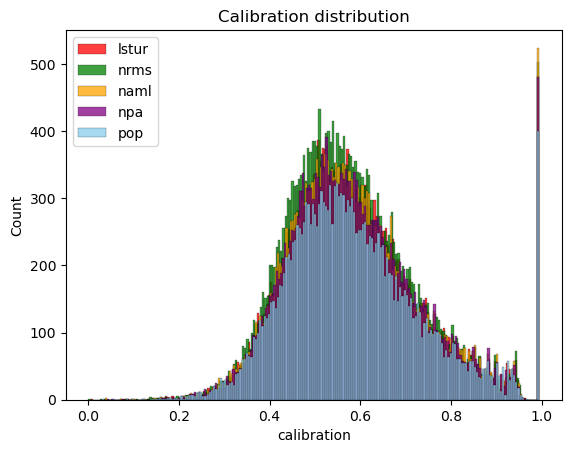

In [8]:
df = df_calibration_all.toPandas()
  
# Plot the histogram thanks to the histplot function
sns.histplot(data=df.loc[(df["algo"] == "lstur"), ["calibration"]], bins=200, x="calibration", color="red", label="lstur", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "nrms"), ["calibration"]], bins=200, x="calibration", color="green", label="nrms", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "naml"), ["calibration"]], bins=200, x="calibration", color="orange", label="naml", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "npa"), ["calibration"]], bins=200, x="calibration", color="purple", label="npa", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "pop"), ["calibration"]], bins=200, x="calibration", color="skyblue", label="pop", kde=False)

plt.title("Calibration distribution")
  
plt.legend(['lstur', 'nrms', 'naml', 'npa', 'pop'])
  
plt.show()

In [9]:
df_calibration_all.groupby('algo').agg(F.mean('calibration').alias('mean_calibration'), 
                                       F.stddev('calibration').alias('stddev_calibration')).show()

23/02/06 14:12:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/02/06 14:12:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/02/06 14:12:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/02/06 14:12:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/02/06 14:12:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/02/06 14:12:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/02/06 14:12:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/02/06 14:12:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/02/06 14:12:32 WARN RowBasedKeyValueBatch: Calling spill() on

23/02/06 14:12:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+-----+------------------+-------------------+
| algo|  mean_calibration| stddev_calibration|
+-----+------------------+-------------------+
|lstur|0.5846468118318968|0.14638931072017247|
|  pop|0.5838522364411468|0.14715790173498292|
| naml|0.5846088641726783|0.14783372378835283|
|  npa|0.5852890087411117|0.14621181689412424|
| nrms|0.5803803476447238|0.14594756226050673|
+-----+------------------+-------------------+



In [ ]:
df = df_representation_all.toPandas()

sns.histplot(data=df.loc[(df["algo"] == "lstur"), ["representation"]], bins=200, x="representation", color="red", label="lstur", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "nrms"), ["representation"]], bins=200, x="representation", color="green", label="nrms", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "naml"), ["representation"]], bins=200, x="representation", color="orange", label="naml", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "npa"), ["representation"]], bins=200, x="representation", color="purple", label="npa", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "pop"), ["representation"]], bins=200, x="representation", color="skyblue", label="pop", kde=False)

plt.title("Representation distribution")
  
plt.legend(['lstur', 'nrms', 'naml', 'npa', 'pop'])
  
plt.show()

In [ ]:
df_representation_all.groupby('algo').agg(F.mean('representation').alias('mean_representation'), 
                                          F.stddev('representation').alias('stddev_representation')).show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = df_fragmentation_all.toPandas()
  
sns.histplot(data=df.loc[(df["algo"] == "lstur"), ["fragmentation"]], bins=200, x="fragmentation", color="red", label="lstur", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "nrms"), ["fragmentation"]], bins=200, x="fragmentation", color="green", label="nrms", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "naml"), ["fragmentation"]], bins=200, x="fragmentation", color="orange", label="naml", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "npa"), ["fragmentation"]], bins=200, x="fragmentation", color="purple", label="npa", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "pop"), ["fragmentation"]], bins=200, x="fragmentation", color="skyblue", label="pop", kde=False)

plt.title("Fragmentation distribution")
  
plt.legend(['lstur', 'nrms', 'naml', 'npa', 'pop'])
  
plt.show()

In [ ]:
display(df_fragmentation_all.groupby('algo').agg(F.mean('fragmentation').alias('mean_fragmentation'), F.stddev('fragmentation').alias('stddev_fragmentation')))

algo,mean_fragmentation,stddev_fragmentation
lstur,0.8051367747077504,0.03334955976549406
pop,0.7808469677567781,0.031611804226194036
naml,0.7886399536233348,0.036384301733478334
npa,0.7969852605739273,0.033223707022773774
nrms,0.7924785881139604,0.034227846507726103
